### Notebook to calculate the PBH threshold
#### ( according to arXiv:2011.03014 )

In [6]:
import numpy as np
import scipy.constants as const
import scipy.special as special
from scipy.special import erfc
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.integrate import dblquad
import scipy.optimize as opt

In [7]:
# default params 
eta = 0.1
k_star =  2.1e6   # k_msun

verbose = 0

class ClassPBHFormationMusco20():

    def __init__(self, 
                       PS_func, 
                       eta=eta,
                       k_star=k_star,                      
                       Pk_scalefactor=1,
                       force_method=True,
                       thermalhistory_func=False):
        # super().__init__()
        self.eta = eta
        self.PS_func= PS_func
        self.k_star = k_star
        self.Pkscalingfactor = Pk_scalefactor
        self.force_method = force_method
        if thermalhistory_func: self.thermalhistory_func

        # if verbose >2: print( 'FormPBHMusco (class) set  Pk to ', Pk_model)

    # List of fnctions for the computations of delta_critical based on the method Musco20
    def TransferFunction(self, k, t):
        sq = 1. / np.sqrt(3)
        arg = k * t * sq
        return 3 * (np.sin(arg) - arg * np.cos(arg)) / arg ** 3

    def PowerSpectrum(self, k, t):
        Pk = self.PS_func 

        P = Pk(k * self.k_star) * self.Pkscalingfactor
        T =  self.TransferFunction(k, t)
        return 2.*np.pi**2 /(k**3) * P * T**2

    def ShapeRHS(self, t, rm=1.0, print_errors=False):
        cos = lambda k: (k ** 4 * np.cos(k * rm) * self.PowerSpectrum(k, t))
        sin = lambda k: (k ** 3 * np.sin(k * rm) * self.PowerSpectrum(k, t))
        cosint = integrate.quad(cos, 0, np.inf, limit=100000, limlst=10000)
        sinint = integrate.quad(sin, 0, np.inf, limit=100000, limlst=10000)
        coserr = cosint[1]
        sinerr = sinint[1]

        if print_errors:
            print("errs = ", coserr, sinerr)

        result = -0.25 * (1 + rm * cosint[0] / sinint[0])
        return result

    def F_alpha(self, a):
        
        arg = 5 / (2 * a)

        # gammainc  ==  inc lower gammar   Normalized  (1/gamma(arg))
        # gammaincc ==  inc upper gammar  Normalized (1/gamma(arg))
        diff = (special.gamma(arg) * special.gammainc(arg, 1 / a))

        if not diff==diff:
            print('diff = ', diff,
                  " \n a=5/(2*alpha), x = 1/alpha , G(a), G_inc(a, x) = ",
                  arg, 1/a, special.gamma(arg),  special.gammainc(arg, 1 / a),  "\n\n" )
            raise Exception('  !!  nan at calc Gammas in F(alpha)')

        disc = 1 - 2 / 5 * np.exp(-1 / a) * a ** (1 - arg) / diff

        if disc < 0 or not disc==disc:
            print('disc = ', disc, "\n\n" )
            raise Exception('  !!  negative  sqrt  or nan in F(alpha)')

        return np.sqrt(disc)

    def get_rm(self, t=None,  guess=1.0, method='root'):

        t = t if t else self.eta

        def _func(rm):
            integrand = lambda k: k ** 2 * (
                        (k ** 2 * rm ** 2 - 1) * np.sin(k * rm) / (k * rm) + np.cos(k * rm)) \
                                  * self.PowerSpectrum(k, t)
            integ = integrate.quad(integrand, 0, np.inf, limit=1000, limlst=100)
            # integ = integrate.quad(integrand, 0, 1e10, limit=100000, limlst=10000)  #TODO: why it crashes without inf
            return integ[0]

        if method == 'root':
            sol = opt.root(_func, x0=guess)
            root = sol.x
            success = sol.success

        else:
            root, success = opt.bisect(_func, 0., 1e8, rtol=1.e-5, maxiter=100, full_output = True)
            # success = True

        if success:
                return float(root)
        else:
                raise Exception("failed to converge in get_rm iteration")

    def ShapeValue(self, t, rm=1.0, guess=0.5, method='root'):

        def _func(a):
            return self.F_alpha(a) * (1 + self.F_alpha(a)) * a - 2 * self.ShapeRHS(t, rm=rm)

        # method = 'bisect' #TODO

        if method == 'root':
            sol = opt.root(_func, x0=guess)
            root = sol.x
            success = sol.success
        else:
            root, success = opt.bisect(_func, 0.01, 100., rtol=1.e-5, maxiter=100, full_output = True)

        if success:
            return float(root)
        else:
            raise Exception("failed to converge in ShapeValue iteration")

    def dcrit(self, a):

        if (a >= 0.1 and a <= 3):
            return a ** 0.125 - 0.05
        if (a > 3 and a <= 8):
            return a ** 0.06 + 0.025
        if (a > 8 and a <= 30):
            return 1.15
        
        else: 
            err_msg = f"\n!!! the value of alpha is out of the allowed window (0.1, 30),\n alpha = {a}\n"
            print(err_msg)
            if self.force_method:  
                raise Exception(err_msg)

            return  np.nan # ClassPBHFormationStandard(self.PS_func).get_deltacr()
        
    def get_deltacr(self):
        # print("getting delta_cr with eta =  ", self.eta,  " kp =", self.kp) #TODO :clean
        
        eta = self.eta       
        if verbose: print(f" we found eta = {eta}")

        rm = self.get_rm(eta)
        if verbose: print(f" we found rm = {rm}")

        alpha = self.ShapeValue(eta, rm=rm)                 #TODO: large alpha values (>30) crashes the code
        if verbose: print(f" we found alpha = {alpha}")

        deltacr = self.dcrit(alpha)
        if verbose: print(f" we found deltacr = {deltacr}")

        return deltacr



In [21]:
AsPBH, kp, sigma = [0.0205, 2.e6, 1.]     ## This example works fine! 
AsPBH, kp, sigma = [0.0205, 2.e6, 0.5]    ## This example crashes... 

def PS_func(kk):
        return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))


method = ClassPBHFormationMusco20(PS_func=PS_func)

dc = method.get_deltacr()

print(" >> delta critical is ", dc)



Exception: failed to converge in get_rm iteration

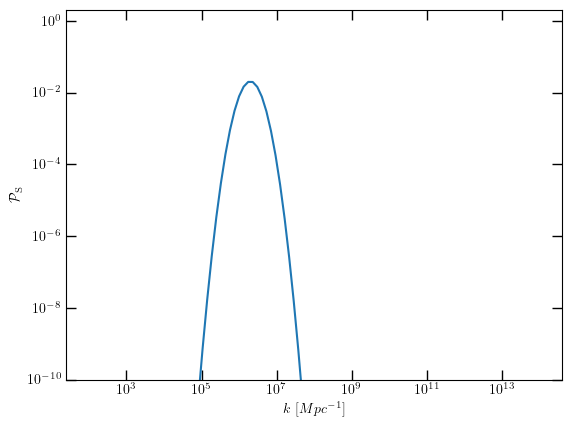

In [22]:
kvals = 10**np.linspace(2,14, 100) 

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib as mpl

mpl.rcParams.update({'font.size': 10,'font.family':'serif'})
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

    
ks = 10**np.linspace(2,14, 100) 
plt.plot(ks , PS_func(ks))
plt.ylim(1e-10, 2)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\mathcal{P}_{\rm S}$")
plt.xlabel(r"$k\ [Mpc^{-1}]$")
plt.show()
